# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gdown
import tensorflow as tf
import tensorflow.keras.backend as K
import joblib
import json

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Load Dataset

In [2]:
# Load dataset
df_url = 'https://drive.google.com/uc?id=11ev-8TxeOo_K9ToC08OCnmOnhyxJY-r-'
df_output = 'model2_dataset.csv'
gdown.download(df_url, df_output, quiet=False)
df = pd.read_csv(df_output)

Downloading...
From: https://drive.google.com/uc?id=11ev-8TxeOo_K9ToC08OCnmOnhyxJY-r-
To: /content/model2_dataset.csv
100%|██████████| 28.7M/28.7M [00:00<00:00, 162MB/s]


In [3]:
df

,ketinggian,jarak,elevation_gain,temp,humidity,precipprob,windspeed,difficulty_score,estimated_time
0,1900,11000,1000,24.8,85.6,100.0,13.0,2.387116,4.789685
1,2087,10100,790,27.4,86.3,100.0,24.1,2.150040,4.054063
2,2590,9000,600,25.6,84.8,100.0,22.3,1.862378,3.321466
3,2365,3500,350,25.6,84.8,100.0,22.3,1.202294,1.437628
4,2096,14600,1462,27.1,86.9,100.0,24.1,3.134131,7.035516
...,...,...,...,...,...,...,...,...,...
396087,3035,7500,700,18.7,92.3,100.0,6.5,1.818466,3.151591
396088,2050,11000,1100,28.9,77.5,100.0,16.6,2.477656,5.032654
396089,875,13200,735,27.7,71.2,0.0,8.3,1.987669,4.633234
396090,2897,8900,1300,24.9,86.6,100.0,18.0,2.443158,4.910900


# EDA

In [4]:
df.isna().sum()

,0
ketinggian,0
jarak,0
elevation_gain,0
temp,0
humidity,0
precipprob,0
windspeed,0
difficulty_score,0
estimated_time,0


In [5]:
df.duplicated().sum()

np.int64(0)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396092 entries, 0 to 396091
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ketinggian        396092 non-null  int64  
 1   jarak             396092 non-null  int64  
 2   elevation_gain    396092 non-null  int64  
 3   temp              396092 non-null  float64
 4   humidity          396092 non-null  float64
 5   precipprob        396092 non-null  float64
 6   windspeed         396092 non-null  float64
 7   difficulty_score  396092 non-null  float64
 8   estimated_time    396092 non-null  float64
dtypes: float64(6), int64(3)
memory usage: 27.2 MB


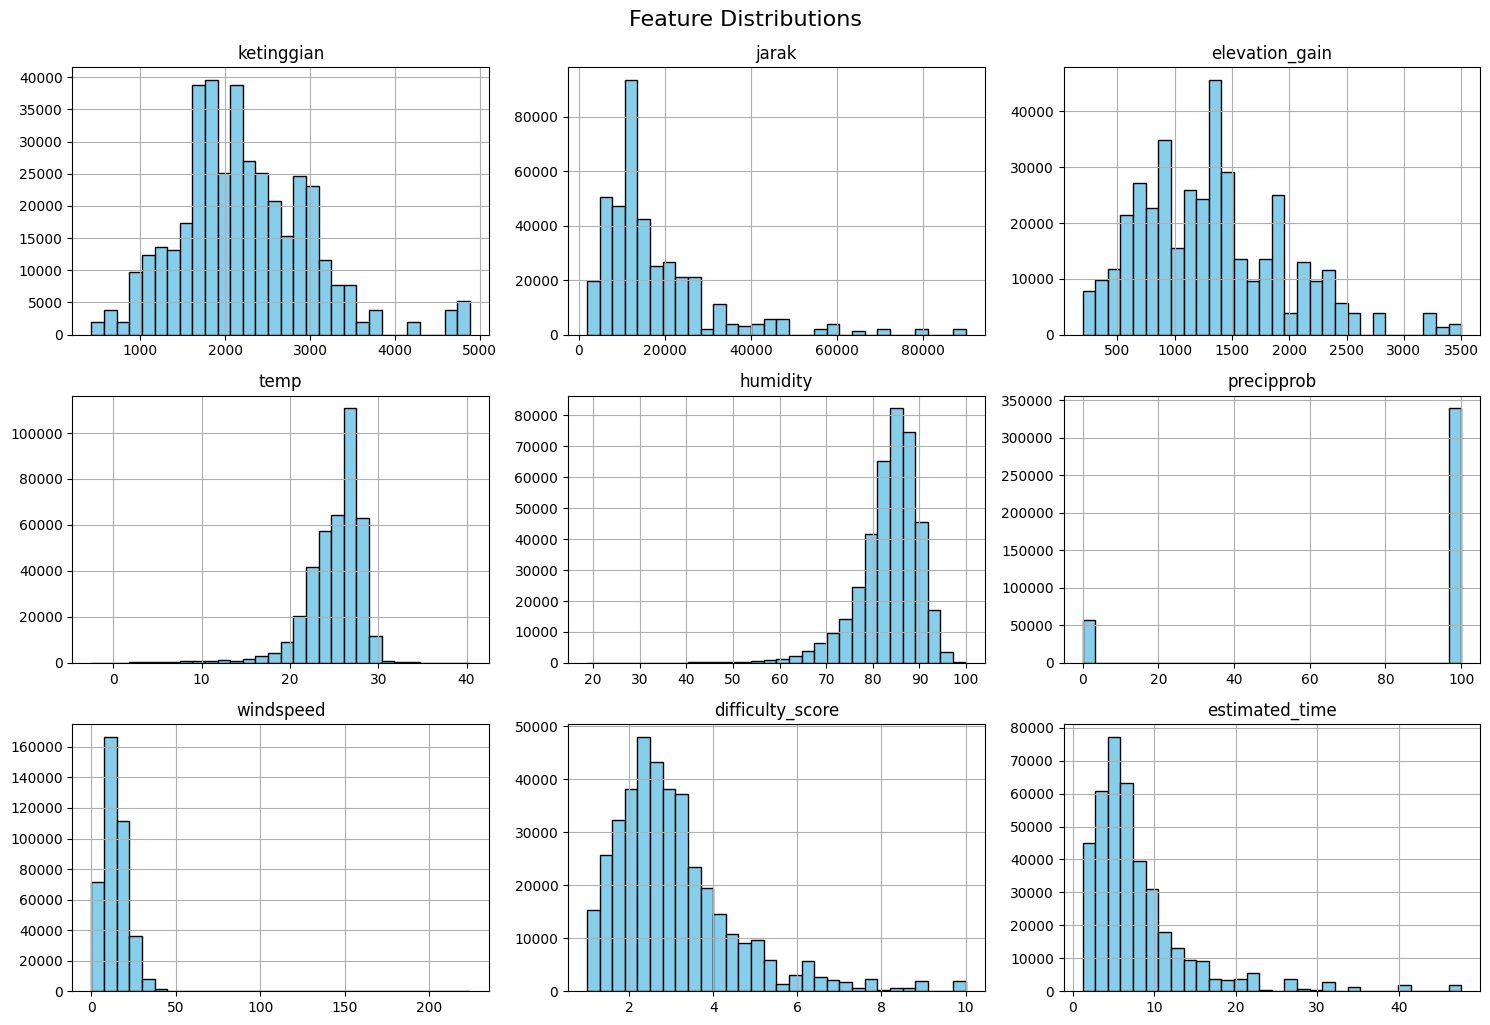

In [7]:
# Histograms
df.hist(bins=30, figsize=(15, 10), color='skyblue', edgecolor='black')
plt.tight_layout()
plt.suptitle("Feature Distributions", fontsize=16, y=1.02)
plt.show()

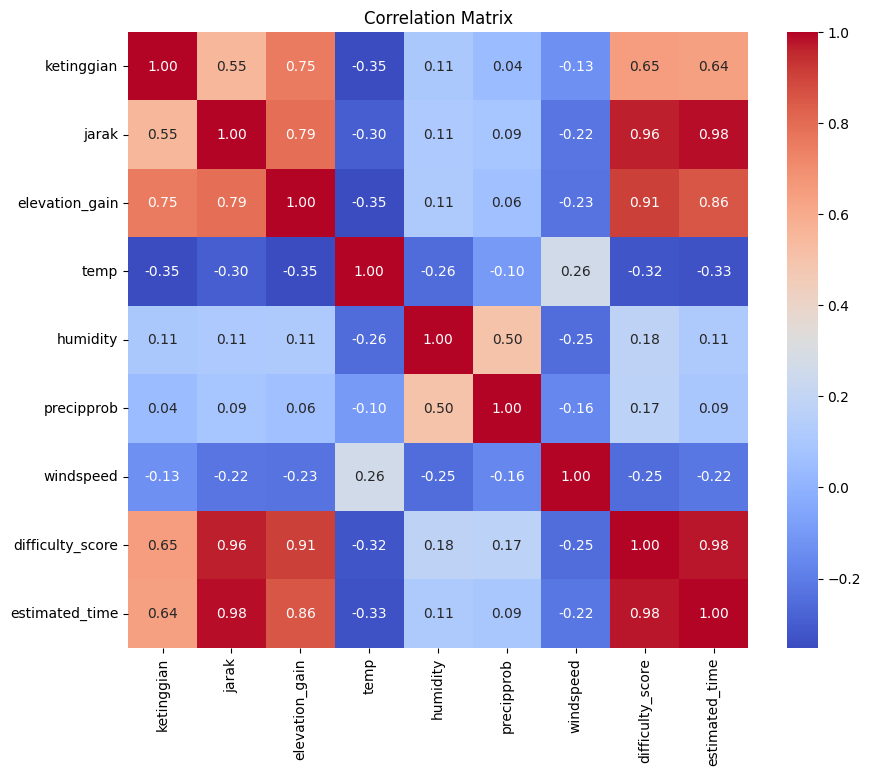

In [8]:
# Correlation Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

# Preprocessing

In [9]:
features = ['ketinggian', 'jarak', 'elevation_gain', 'temp', 'precipprob', 'windspeed', 'humidity']
target = ['difficulty_score', 'estimated_time']
X = df[features]
y = df[target]

In [10]:
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Scale
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model Building

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2)
])

In [13]:
# Evaluation function
def mean_absolute_percentage_error(y_true, y_pred):
    y_true = K.clip(y_true, K.epsilon(), None)
    diff = K.abs((y_true - y_pred) / y_true)
    return 100. * K.mean(diff)

def adjusted_r2_score(y_true, y_pred, n_features):
    r2 = r2_score(y_true, y_pred)
    n = len(y_true)
    return 1 - (1 - r2) * (n - 1) / (n - n_features - 1)

In [14]:
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae', mean_absolute_percentage_error]
)

print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,410 (36.76 KB)

 Trainable params: 9,410 (36.76 KB)

 Non-trainable params: 0 (0.00 B)

None


In [15]:
# Callbacks
checkpoint = ModelCheckpoint(
    filepath="saved_model/best_model.keras",
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

In [16]:
# Train
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=10,
    batch_size=32,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

Epoch 1/10
9903/9903 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.3094 - mae: 0.3618 - mean_absolute_percentage_error: 7.2759
Epoch 1: val_loss improved from inf to 0.00132, saving model to saved_model/best_model.keras
9903/9903 ━━━━━━━━━━━━━━━━━━━━ 45s 4ms/step - loss: 2.3092 - mae: 0.3618 - mean_absolute_percentage_error: 7.2754 - val_loss: 0.0013 - val_mae: 0.0218 - val_mean_absolute_percentage_error: 0.5921
Epoch 2/10
9888/9903 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0021 - mae: 0.0298 - mean_absolute_percentage_error: 0.7400
Epoch 2: val_loss improved from 0.00132 to 0.00080, saving model to saved_model/best_model.keras
9903/9903 ━━━━━━━━━━━━━━━━━━━━ 68s 3ms/step - loss: 0.0021 - mae: 0.0298 - mean_absolute_percentage_error: 0.7399 - val_loss: 8.0258e-04 - val_mae: 0.0221 - val_mean_absolute_percentage_error: 0.5707
Epoch 3/10
9891/9903 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0011 - mae: 0.0210 - mean_absolute_percentage_error: 0.5190
Epoch 3: val_loss improved from 0.00080 to

# Evaluation

In [19]:
y_pred = model.predict(X_test_scaled)

2476/2476 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


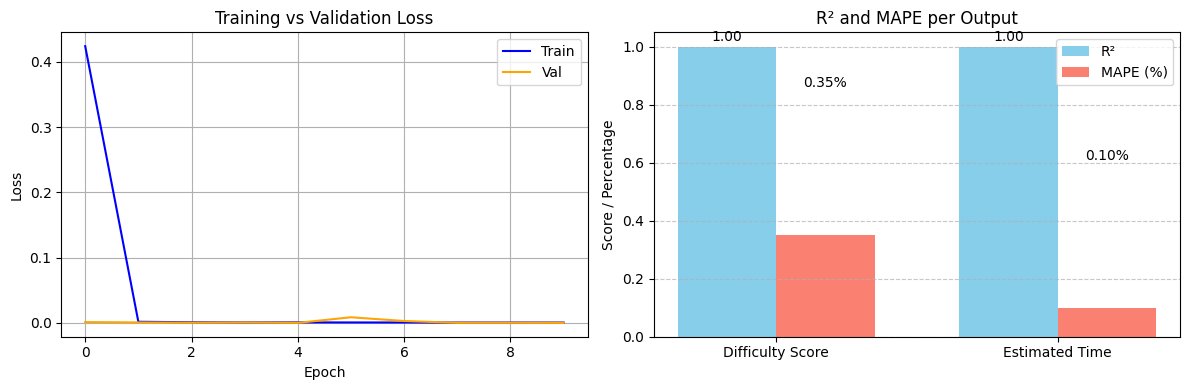

In [20]:
# Plot training history and metrics
def plot_metrics(history, y_true, y_pred, titles):
    r2_list, mape_list = [], []

    for i, name in enumerate(titles):
        true = y_true[:, i]
        pred = y_pred[:, i]
        r2 = r2_score(true, pred)
        mape = np.mean(np.abs((true - pred) / np.where(true == 0, np.finfo(float).eps, true))) * 100
        r2_list.append(r2)
        mape_list.append(mape)

    x = np.arange(len(titles))
    width = 0.35
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(history.history['loss'], label='Train', color='blue')
    ax1.plot(history.history['val_loss'], label='Val', color='orange')
    ax1.set_title("Training vs Validation Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend()
    ax1.grid(True)

    ax2.bar(x - width/2, r2_list, width, label='R²', color='skyblue')
    ax2.bar(x + width/2, mape_list, width, label='MAPE (%)', color='salmon')
    ax2.set_ylabel("Score / Percentage")
    ax2.set_title("R² and MAPE per Output")
    ax2.set_xticks(x)
    ax2.set_xticklabels(titles)
    ax2.legend()
    ax2.grid(axis='y', linestyle='--', alpha=0.7)

    for i, v in enumerate(r2_list):
        ax2.text(i - width/2, v + 0.01, f"{v:.2f}", ha='center', va='bottom')
    for i, v in enumerate(mape_list):
        ax2.text(i + width/2, v + 0.5, f"{v:.2f}%", ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

plot_metrics(history, y_test.to_numpy(), y_pred, ['Difficulty Score', 'Estimated Time'])

# Inference

In [21]:
def hours_to_hh_mm(hours):
    total_minutes = int(round(hours * 60))
    hh = total_minutes // 60
    mm = total_minutes % 60
    return f"{hh} jam {mm} menit"

In [22]:
new_input = pd.DataFrame([{
    'ketinggian': 4156,
    'jarak': 18600,
    'elevation_gain': 3825,
    'temp': 24,
    'humidity': 88,
    'precipprob': 80,
    'windspeed': 10
}])

new_scaled = scaler.transform(new_input[features])
pred_difficulty, pred_time = model.predict(new_scaled)[0]
formatted_time = hours_to_hh_mm(pred_time)

print(f"Predicted Difficulty Score: {pred_difficulty:.2f} / 10")
print(f"Estimated Time: {formatted_time}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
Predicted Difficulty Score: 5.10 / 10
Estimated Time: 15 jam 46 menit


# Convert Model

In [23]:
joblib.dump(scaler, "saved_model/minmax_scaler.pkl")

['saved_model/minmax_scaler.pkl']

In [24]:
with open("saved_model/feature_list.json", "w") as f:
    json.dump(features, f)

In [25]:
pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.1 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.34.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [26]:
best_model = tf.keras.models.load_model("saved_model/best_model.keras")
best_model.save("saved_model/model.h5")
best_model.export("saved_model/tf_model")

Saved artifact at 'saved_model/tf_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 7), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  137584589336464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137584589337424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137584589325520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137584589337232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137584589334928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137584589338576: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [27]:
!tensorflowjs_converter --input_format=tf_saved_model \
                       --output_format=tfjs_graph_model \
                       saved_model/tf_model \
                       saved_model/tfjs_model

2025-06-05 12:39:05.200802: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749127145.234479    3587 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749127145.244720    3587 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-06-05 12:39:15.389535: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1749127155.389749    3587 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

In [28]:
!pip freeze | grep -E "pandas|matplotlib|seaborn|numpy|scikit-learn|gdown|joblib|tensorflow" > requirements.txt

from google.colab import files
files.download('requirements.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>